In [206]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
#plt.rcParams['figure.figsize'] = [150, 100]

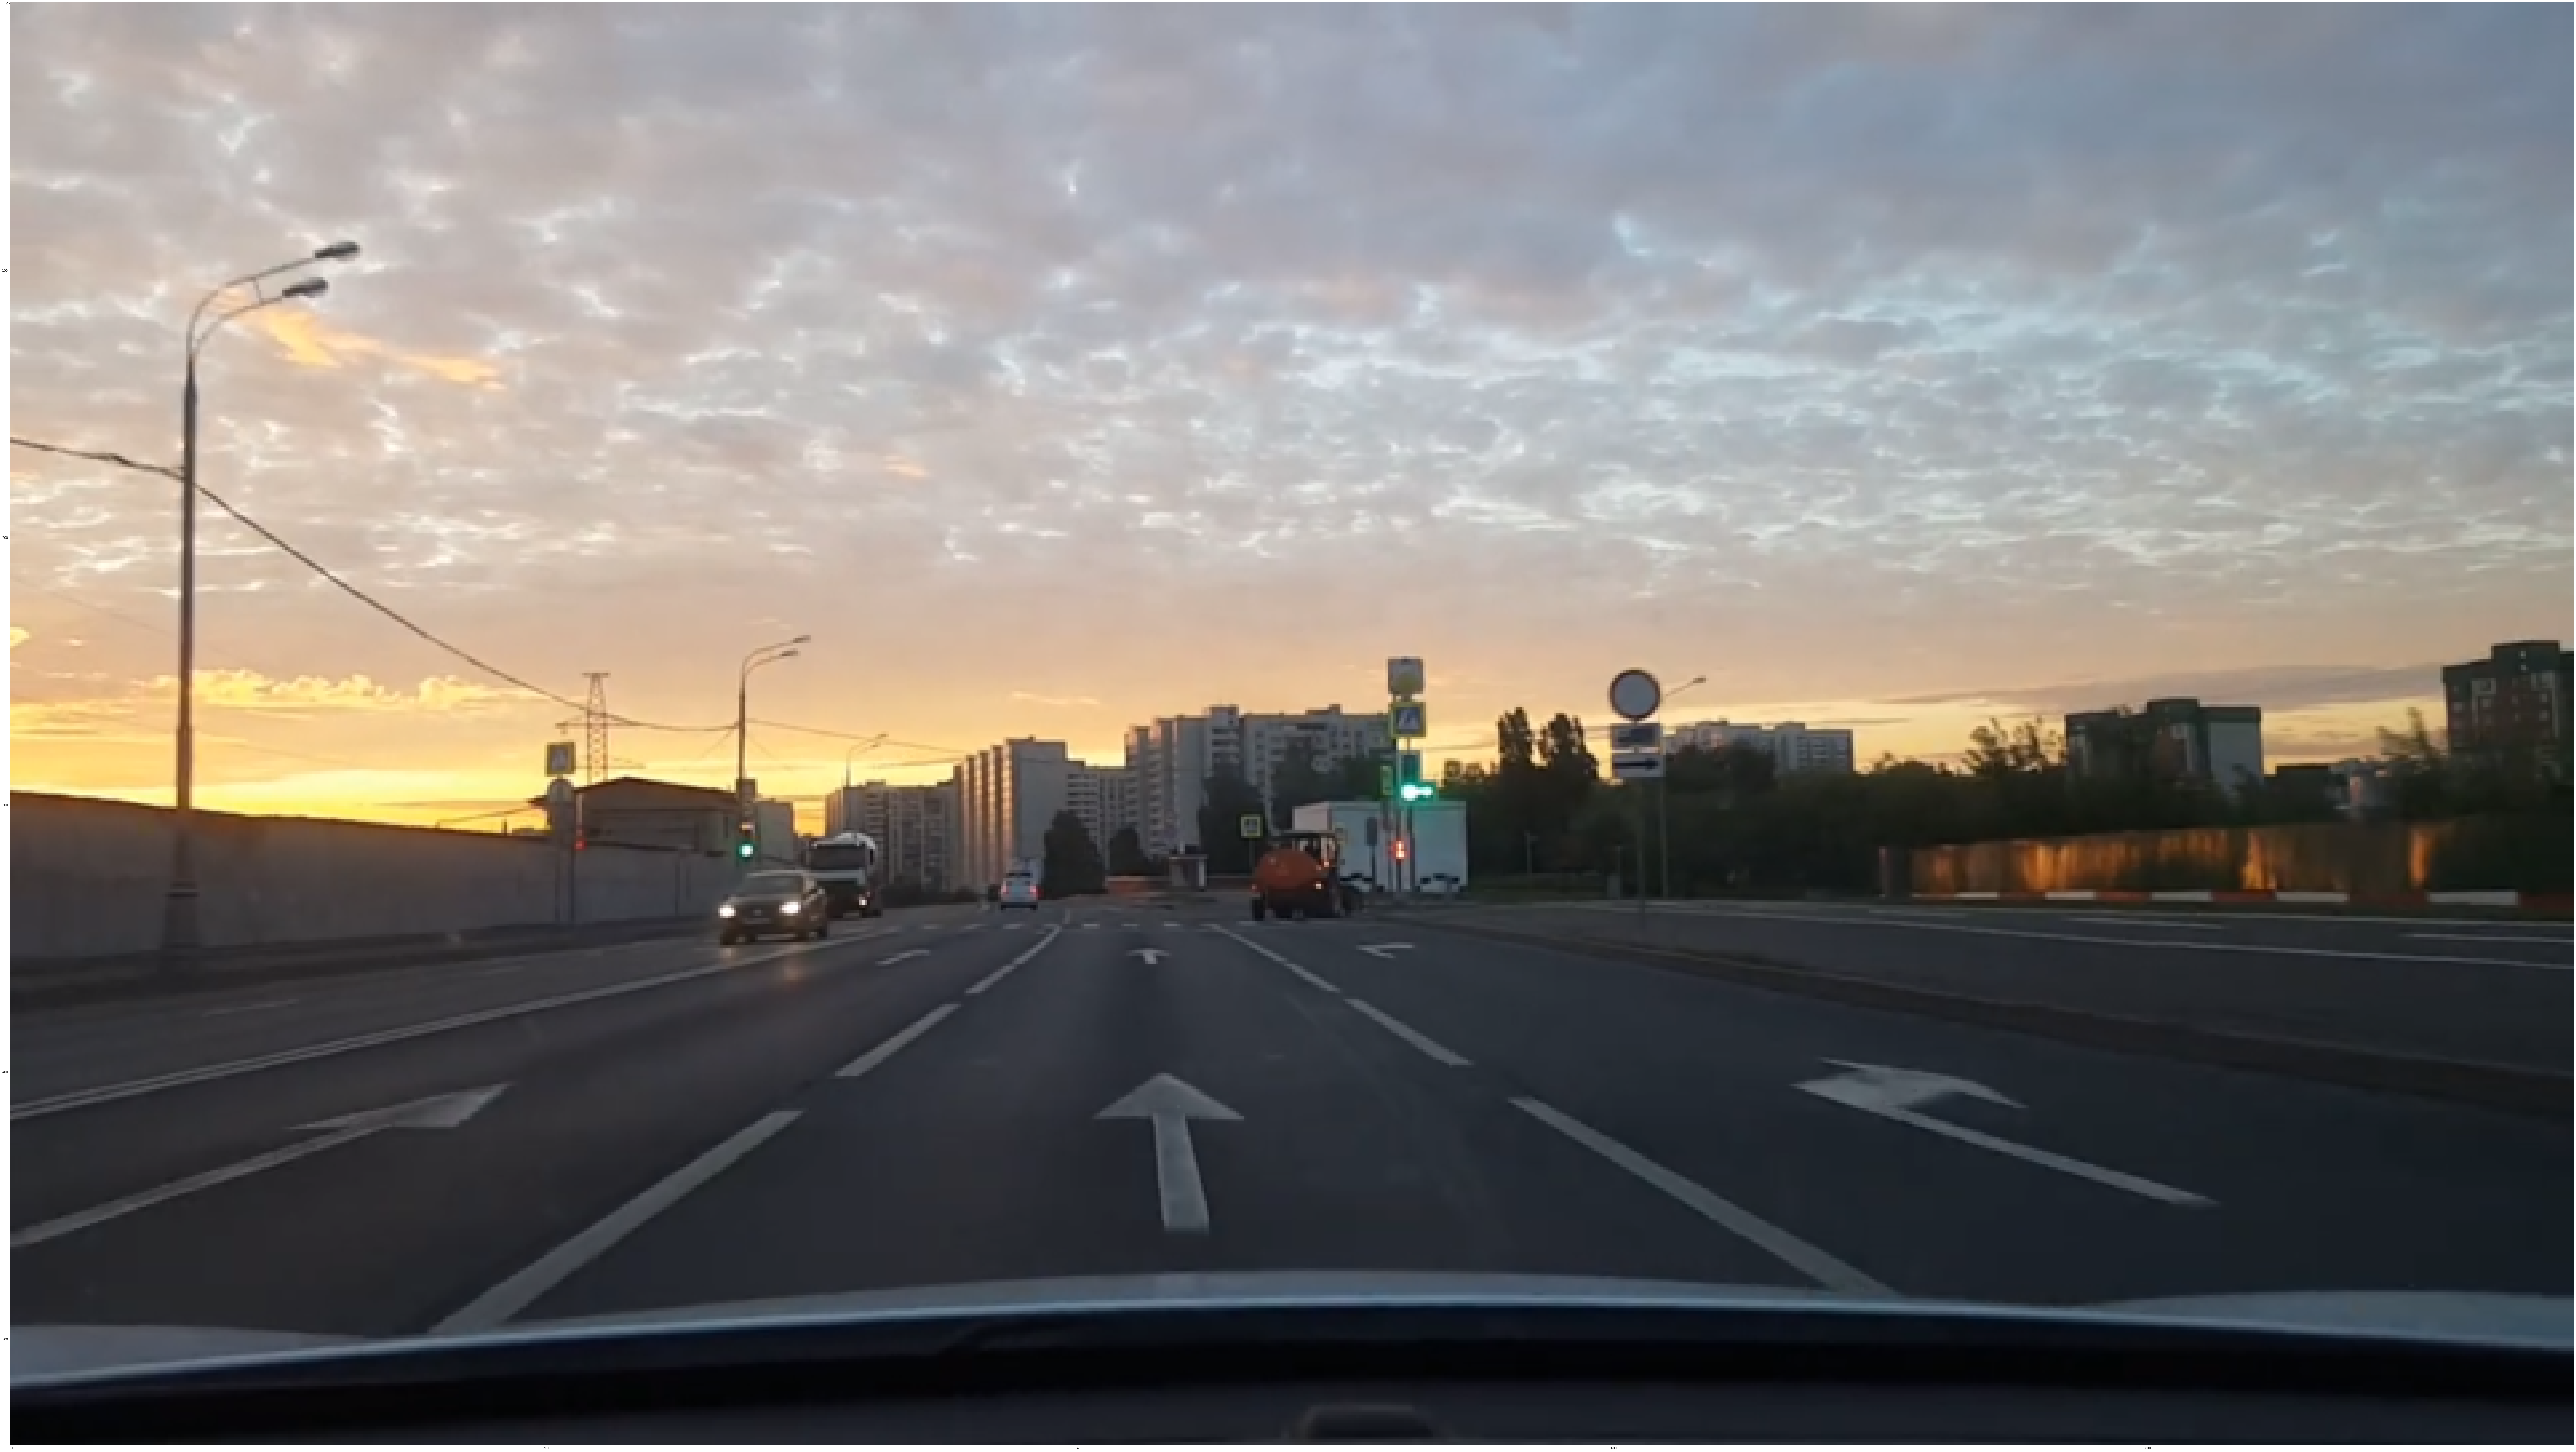

In [207]:
img = cv2.imread('car_view.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

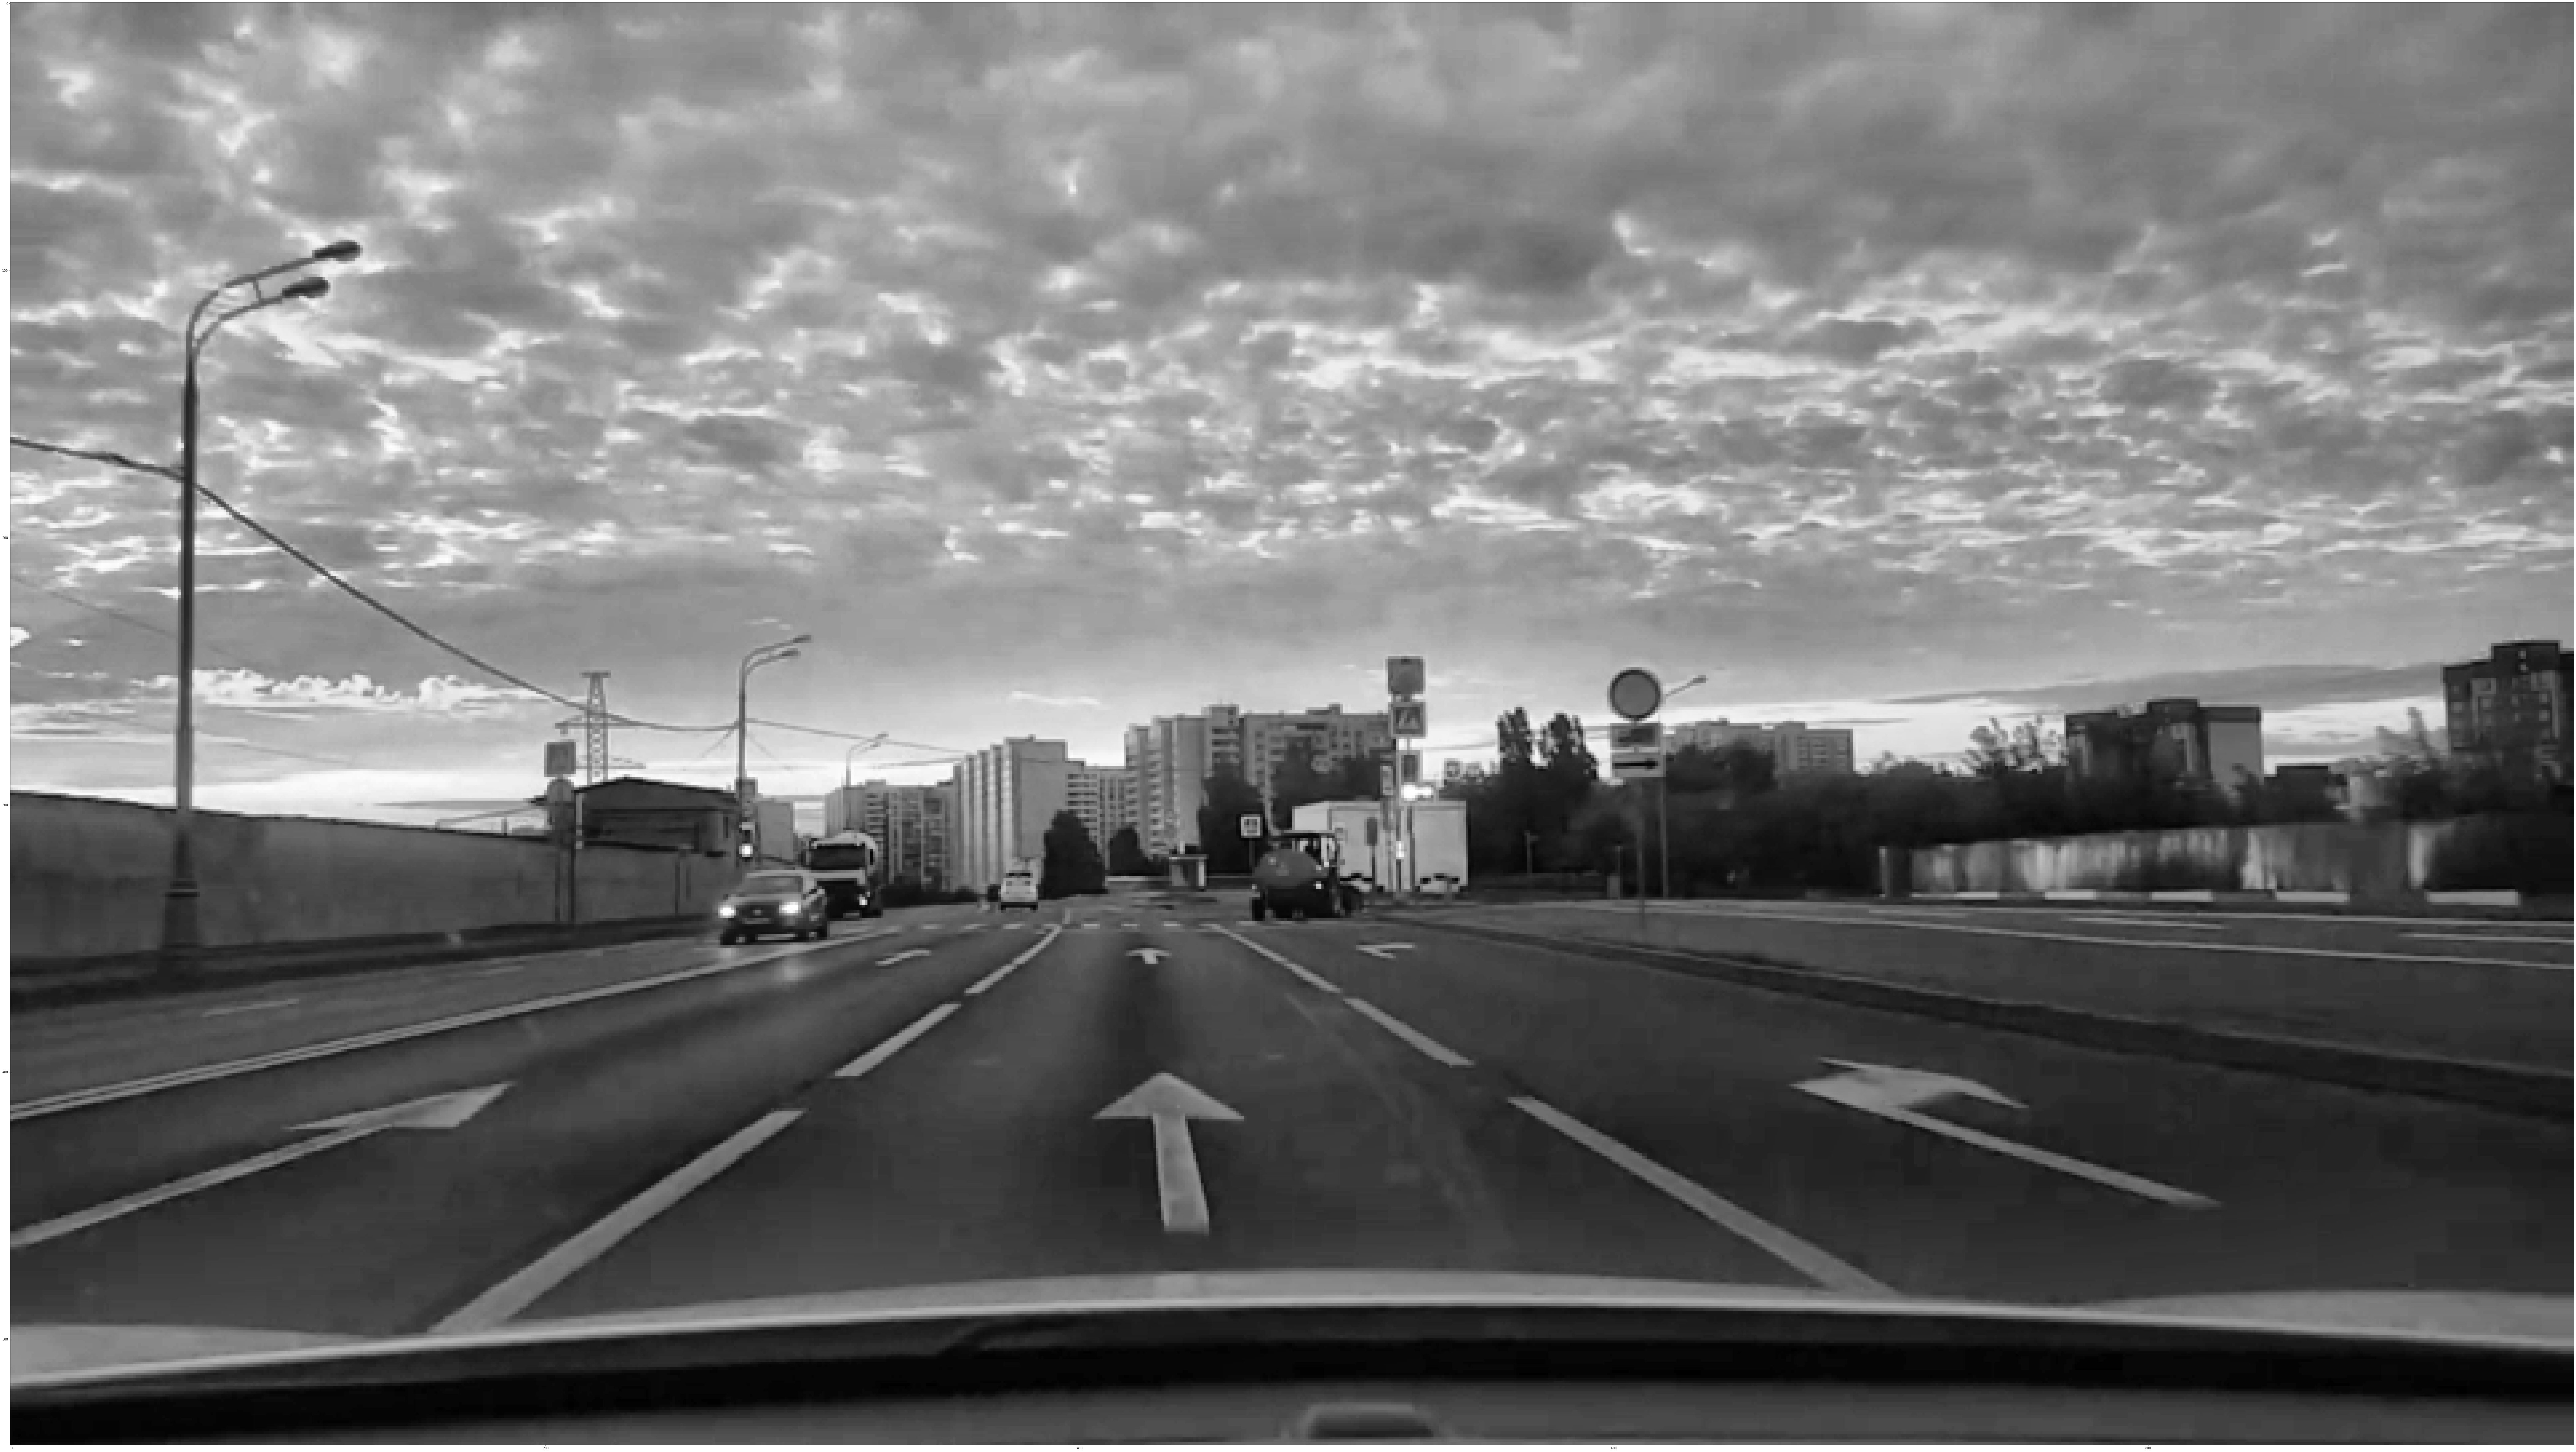

In [208]:
# Convert image to gray scale
gray_first = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Improve image quality by CLAHE 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray = clahe.apply(gray_first)
plt.imshow(gray, cmap='gray')

In [209]:
# Save the shape parameters of the image
row, coll = gray.shape
x, y = gray.shape
print(row, coll)

540 960


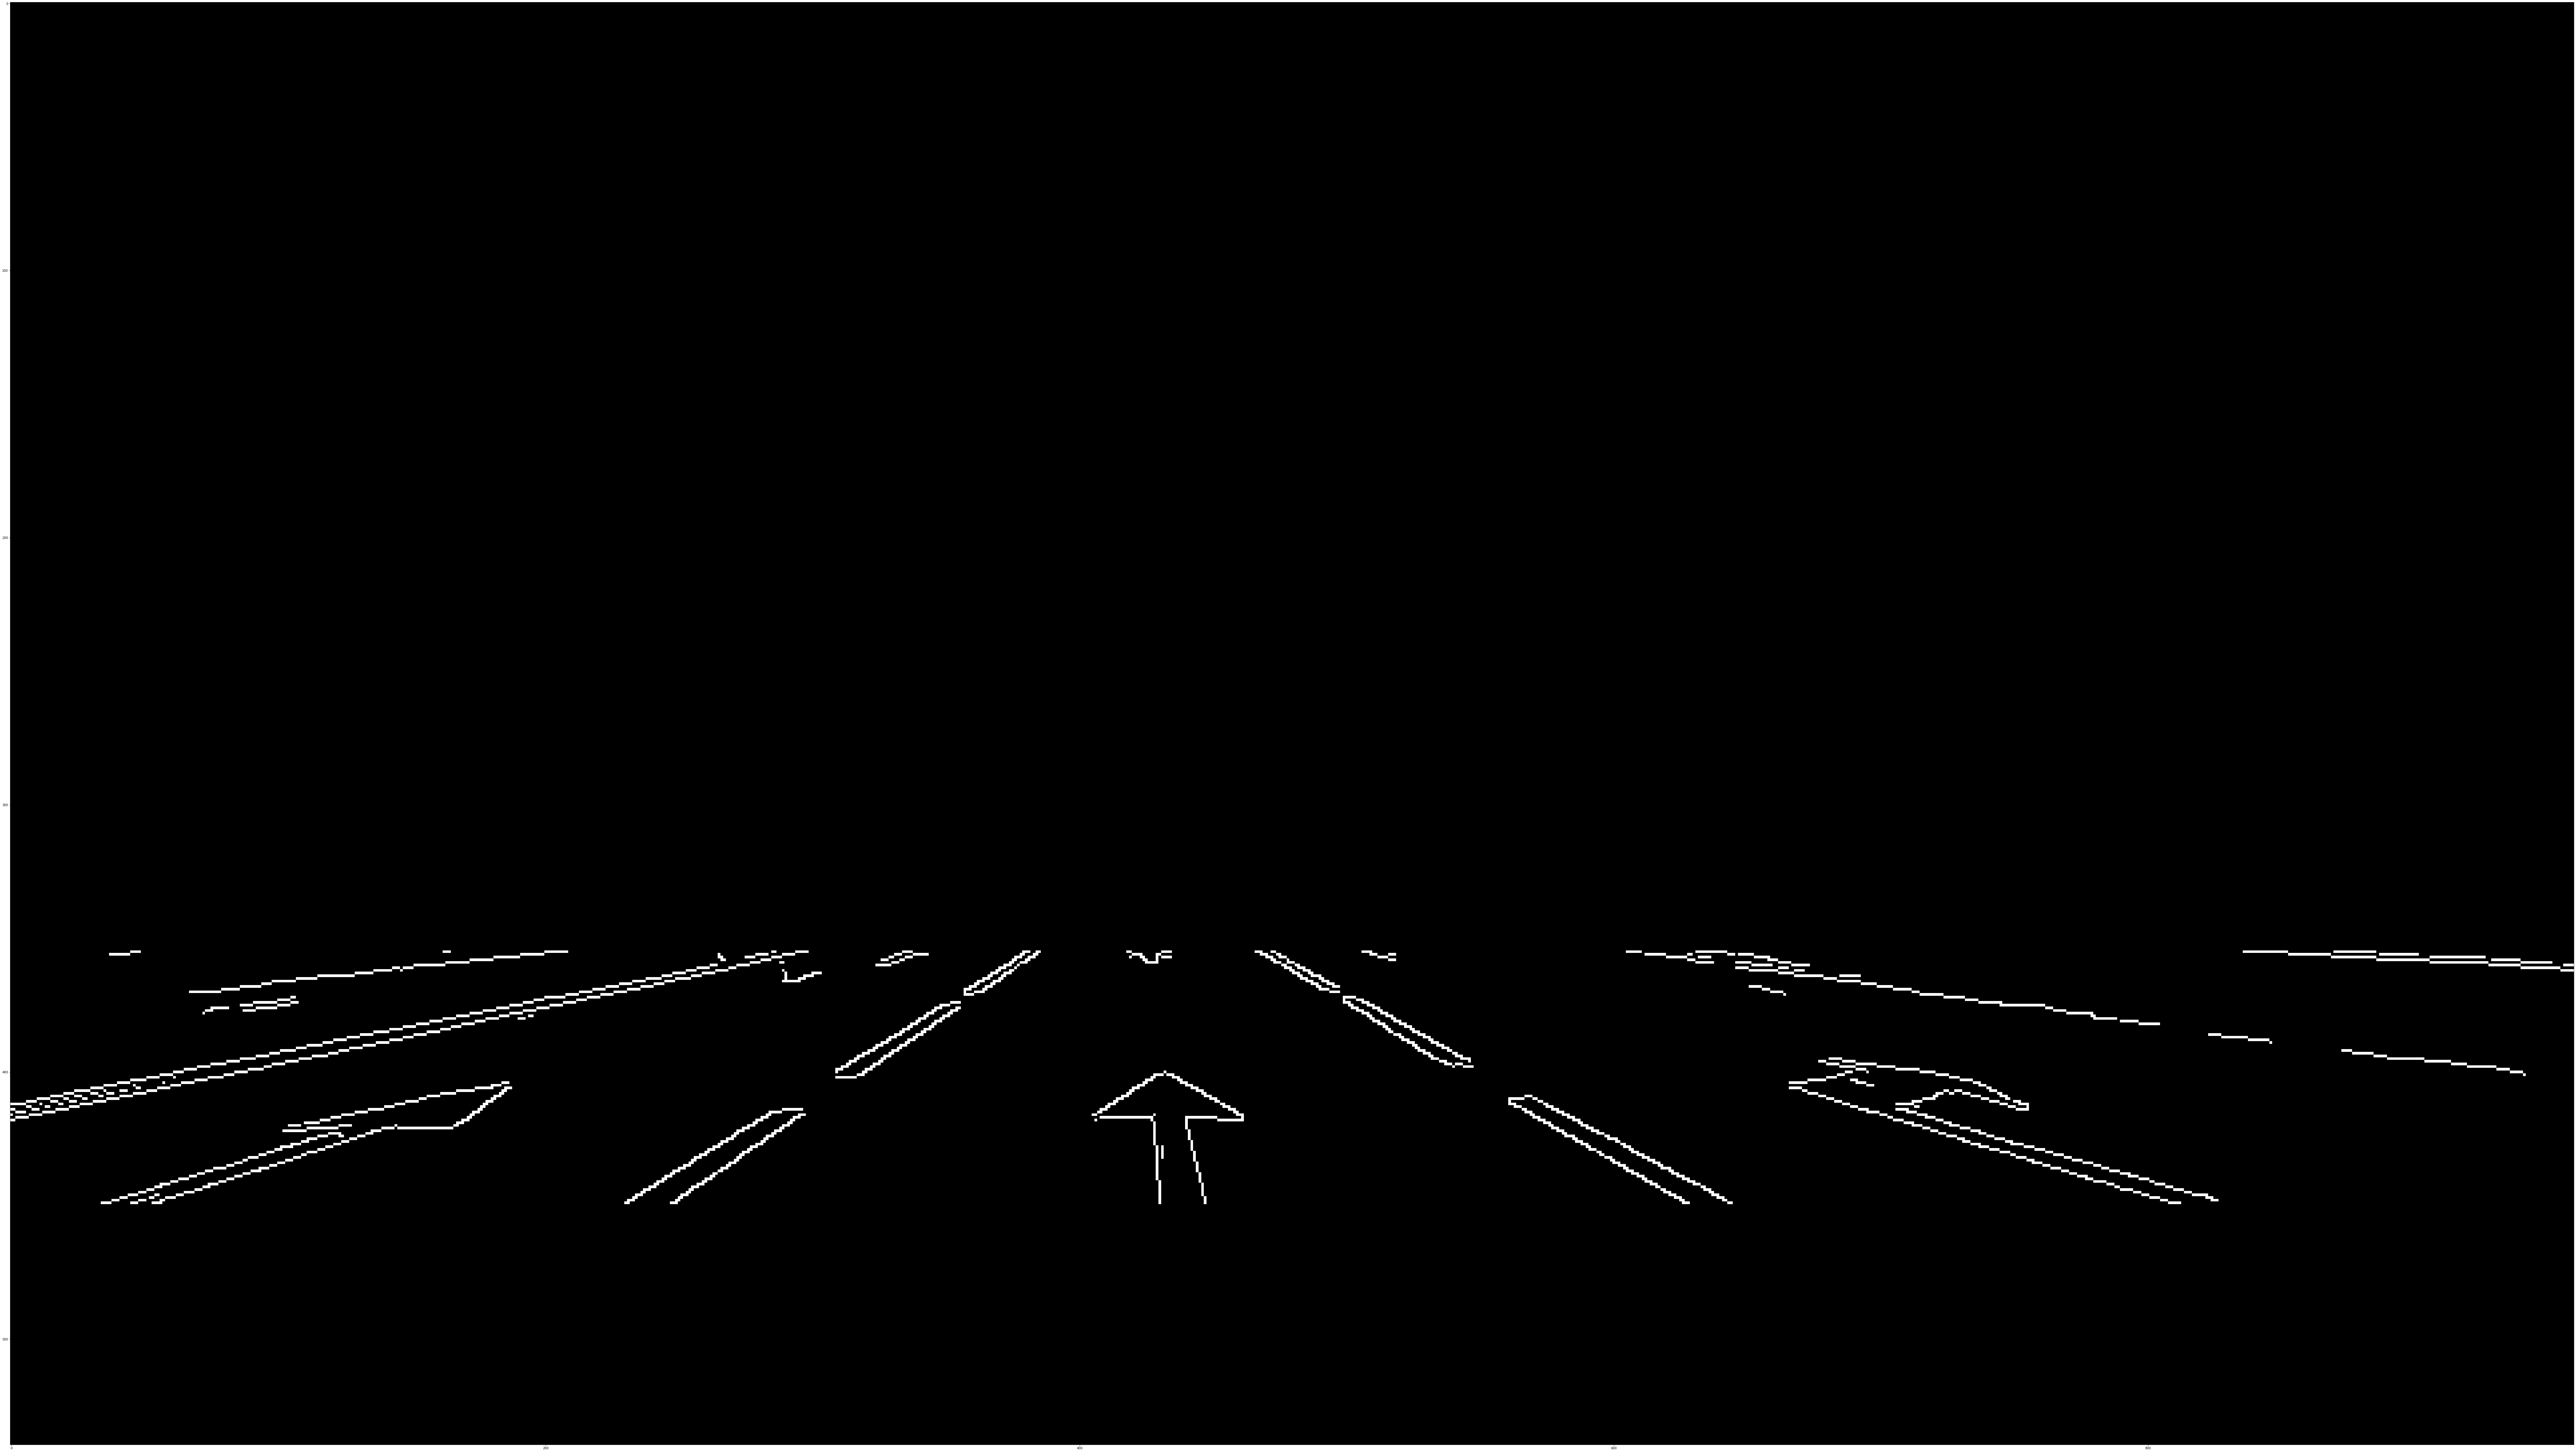

In [210]:
# Use Canny filter for edge detection
edges = cv2.Canny(gray, threshold1= 100, threshold2 = 150)
#  Dimensions of "vision belt" - part of the frame we need for line detection
y1_up = 355
y2_down = 450
edges[0:y1_up] = 0
edges[y2_down:row] = 0
plt.imshow(edges, cmap='gray')

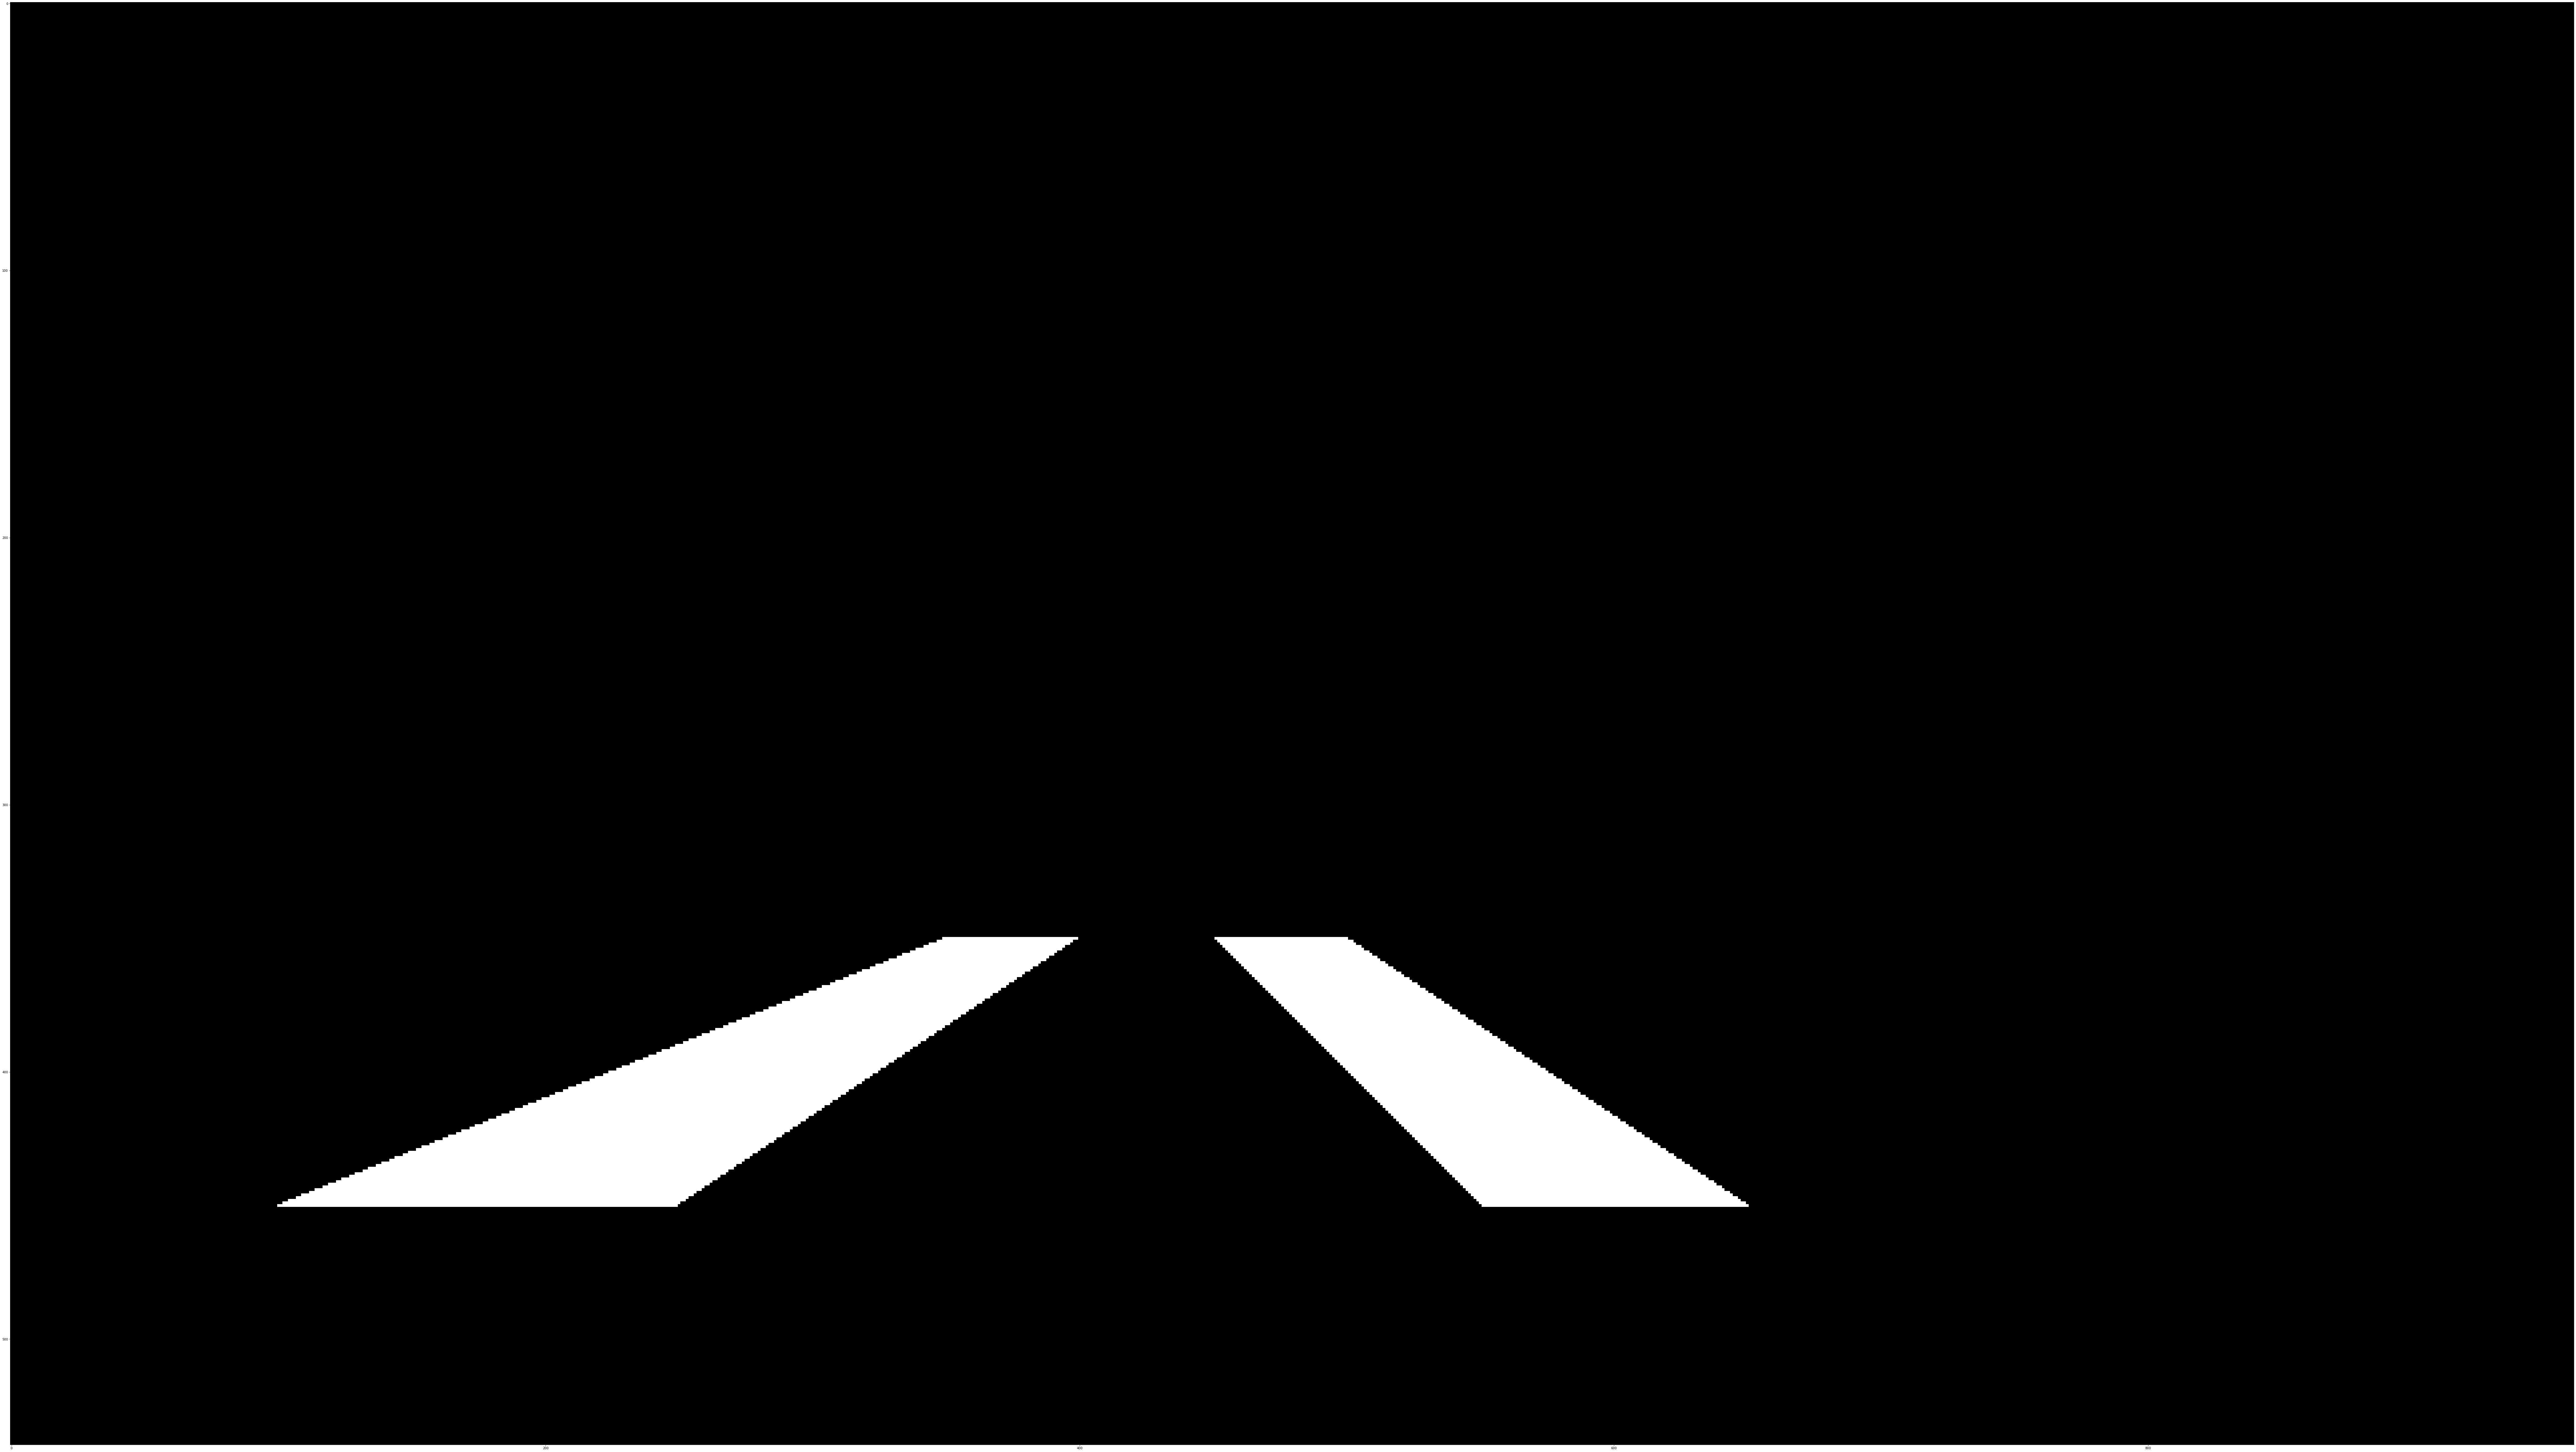

In [211]:
# create a zero array
zero_edges = np.zeros_like(edges)

# Masked the edges by two polygones.
polygon = np.array([[100,450], [350,350], [500,350], [650,450]])
mask = cv2.fillConvexPoly(zero_edges, polygon, 1)
polygon2 = np.array([[250,450], [400,350], [450,350], [550,450]])
mask2 = cv2.fillConvexPoly(mask, polygon2, 0)
plt.imshow(mask2, cmap= "gray")

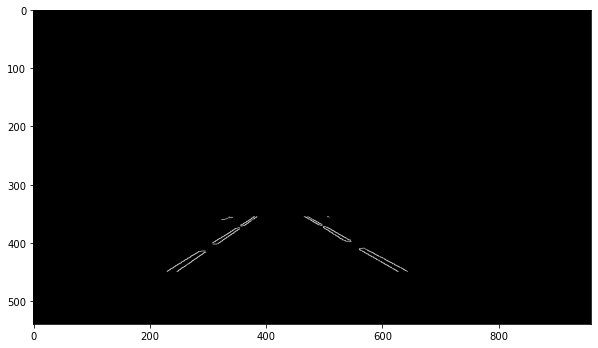

In [212]:
# apply polygon as a mask on the frame
edges_masked = cv2.bitwise_and(edges, edges, mask=mask2)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(edges_masked, cmap= "gray")
plt.show()

In [213]:
# Use probabilistic Hough transform
rho = 1 #The resolution of the parameter r in pixels.
theta = np.pi/90 #The resolution of the parameter θ in radians.
threshold = 20 # The minimum number of intersections to detect a line
#maxLineGap: The maximum gap between two points to be considered in the same line.
lines = cv2.HoughLinesP(edges_masked, rho, theta, threshold, maxLineGap=200)
print(len(lines))
# HoughLinesP returns the coordinates of two points for each detected line.

8


In [214]:
print(lines)

[[[230 449 381 355]]

 [[255 443 385 355]]

 [[468 355 641 447]]

 [[466 355 628 449]]

 [[247 449 370 366]]

 [[526 391 626 449]]

 [[475 357 546 395]]

 [[477 361 639 447]]]


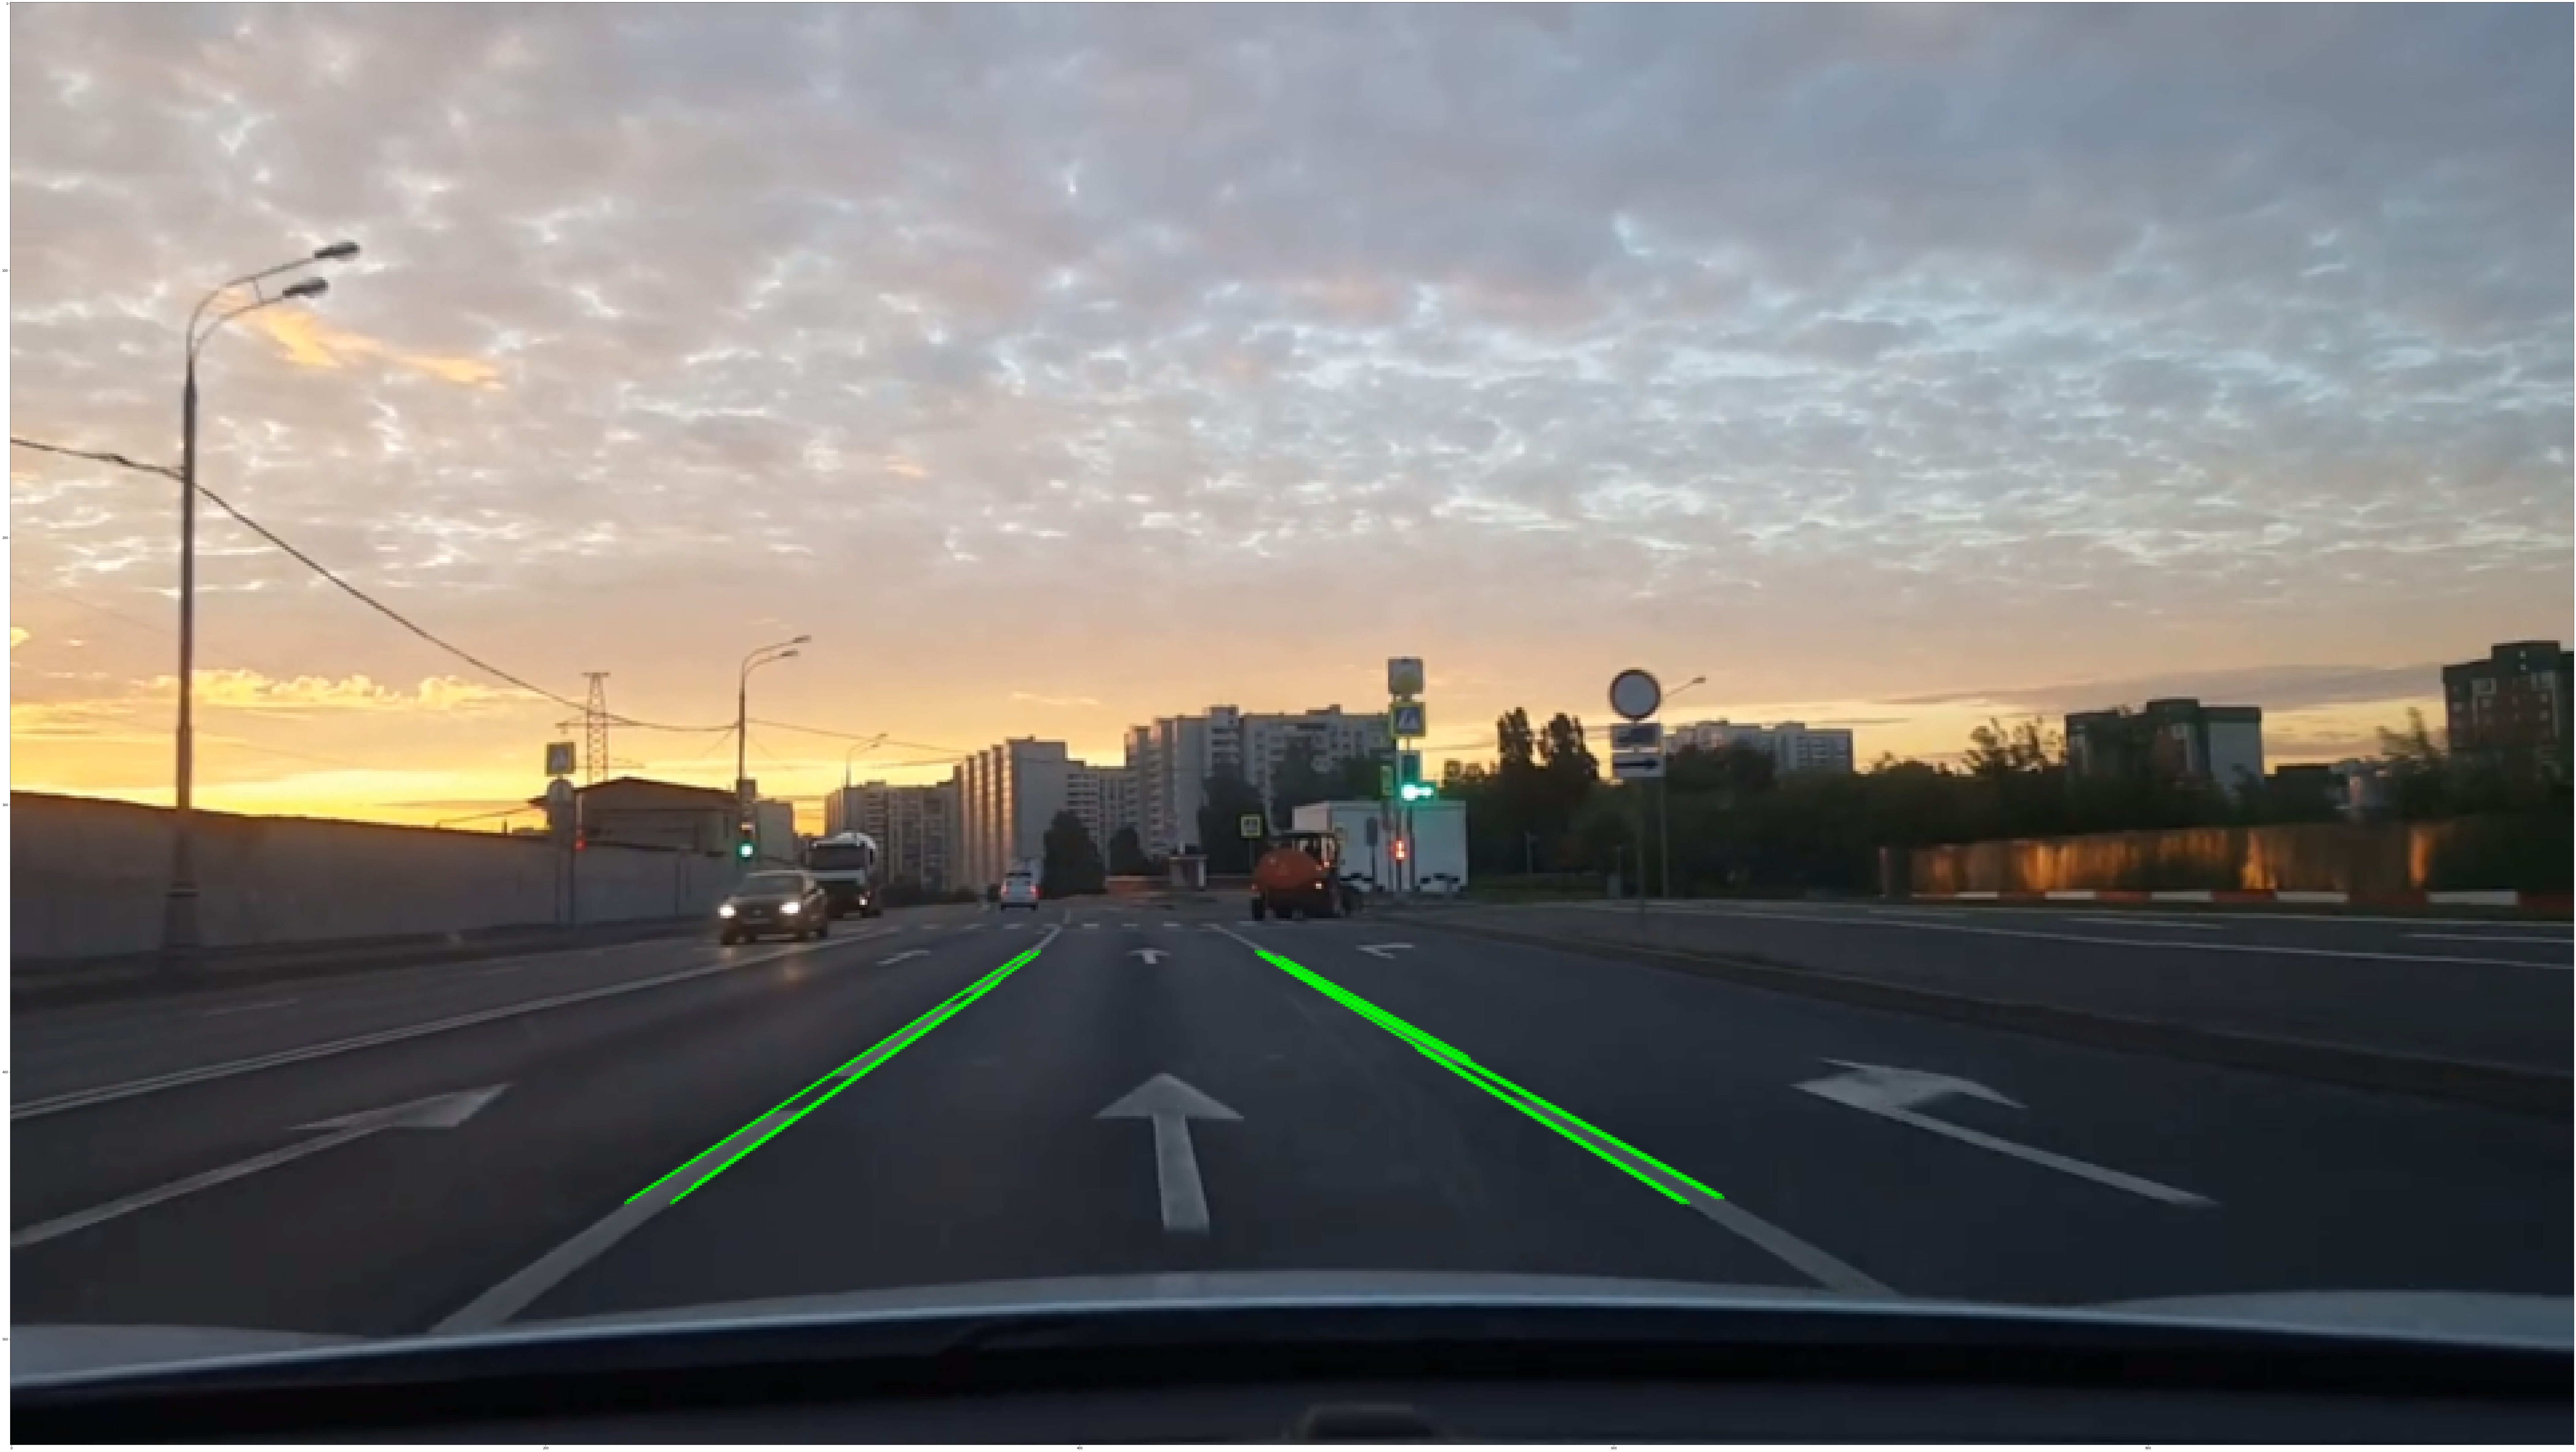

In [215]:
# Plot the lines.

pre_result = np.copy(img)
for i in range(len(lines)):
    for x1,y1,x2,y2 in lines[i]:
        pre_result = cv2.line(pre_result, (x1,y1), (x2,y2), (0,255,0), 1, cv2.LINE_AA)
plt.rcParams['figure.figsize'] = [150, 100]
plt.imshow(pre_result)

In [216]:
# Calculations  of k  for y=kx+b equation.
k = []
for i in range (len(lines)):
    x1, y1, x2, y2 = lines[i][0]
    k.append((y2-y1)/(x2-x1))
print(k)

[-0.6225165562913907, -0.676923076923077, 0.5317919075144508, 0.5802469135802469, -0.6747967479674797, 0.58, 0.5352112676056338, 0.5308641975308642]


In [217]:
# Calculations  of b for y=kx+b equation.
b = []
for i in range(len(lines)):
    x1,y1,x2,y2 = lines[i][0]
    b.append(y1-k[i]*x1)


In [218]:
# Make a dict k and b
k_and_b = dict(zip(k,b))
#b_and_k = dict(zip(b,k))


In [219]:
#Divide the list of k to left and right k. Filter the horizontal lines.

left_k = []
right_k = []
for i in k:
    if i<-0.3:
        left_k.append(i)
    else: 
        if i>0.3:
            right_k.append(i)

In [220]:
#Divide the list of b to left and right b depends on k. Make dict of left and right lines.
left_b = []
for i in left_k:
    left_b.append(k_and_b[i])
left_lines = dict(zip(left_b, left_k))

right_b = []
for i in right_k:
    right_b.append(k_and_b[i])
right_lines = dict(zip(right_b, right_k))

In [221]:
# Take only one left and right line according to conditions bellow. 

result_b_left = max(left_lines.keys())
result_k_left = left_lines[max(left_lines.keys())]

result_b_right = min(right_lines.keys())
result_k_right = right_lines[min(right_lines.keys())]

In [222]:
# Calculate coordinates x for left and right lines using y coordinates we 

x1_left = int((y1_up-result_b_left)/result_k_left)
x2_left = int((y2_down-result_b_left)/result_k_left)

x1_right = int((y1_up-result_b_right)/result_k_right)
x2_right = int((y2_down-result_b_right)/result_k_right)
print(x1_left,x2_right)
print(x1_right, x2_right)
print(y1_up,y2_down)

386 629
466 629
355 450


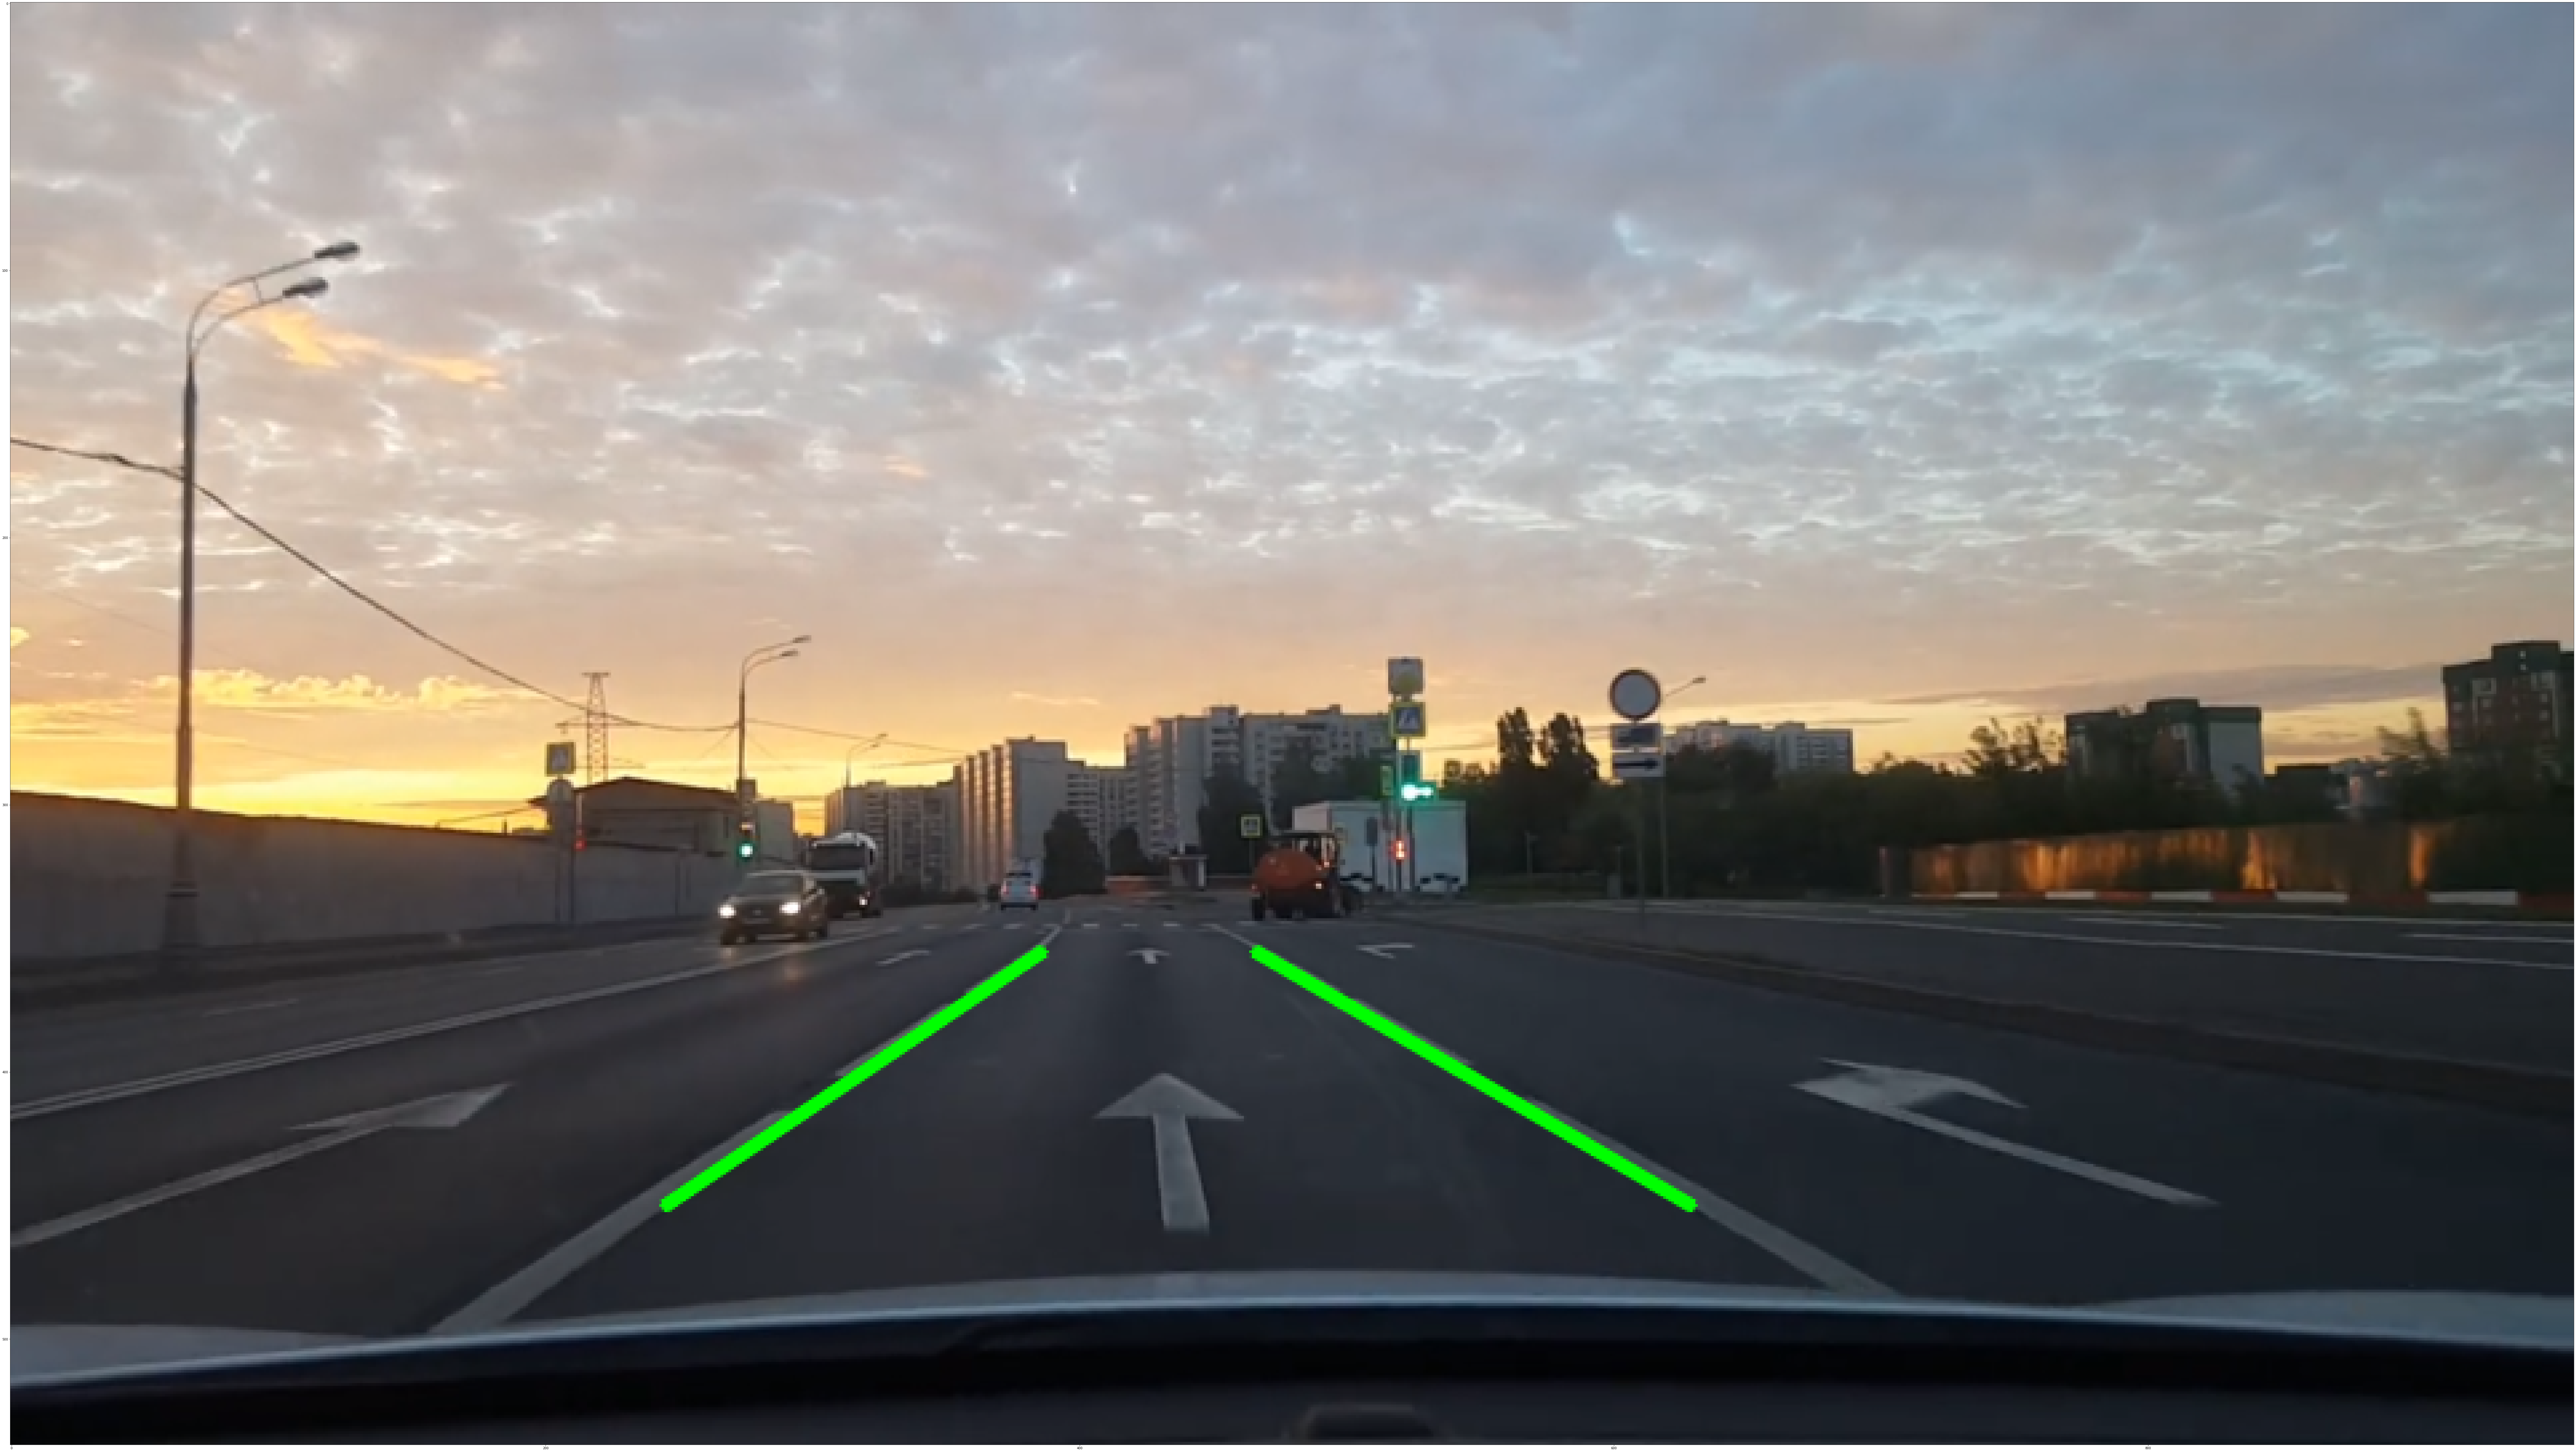

In [223]:
#Plot the result 

result = np.copy(img)

result = cv2.line(result, (x1_left,y1_up), (x2_left,y2_down), (0,255,0), 3, cv2.LINE_AA)
result = cv2.line(result, (x1_right,y1_up), (x2_right,y2_down), (0,255,0), 3, cv2.LINE_AA)

plt.rcParams['figure.figsize'] = [150, 100]
plt.imshow(result)